# Optimization Project_3_ Variable Selection

Contributors: Nittala Venkata Sai Aditya (vn5227), Muskaan Singhania (ms88283), Varun Kausika (vsk394), Yingjia Shang (ys23737)

In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# import files
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

## Problem Description

Variable selection (also known as best subset selection) is a problem encountered in predictive analytics where we have to pick the subset $k$ features from a total of $m$ features.

The total number of models that can be picked are:

$${m \choose 0} + {m \choose 1} + ... + {m\choose m} = 2^m$$

But this would be computationally intensive, and choosing the best subset of variables is considered a np-hard problem. Some workarounds like branch and bound exist to eliminate some possibilities. More recent techniques include solving the mixed integer quadratic program and LASSO, which we implement here.

In [2]:
train.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [3]:
test.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


## Checking if there are any null values in the datasets

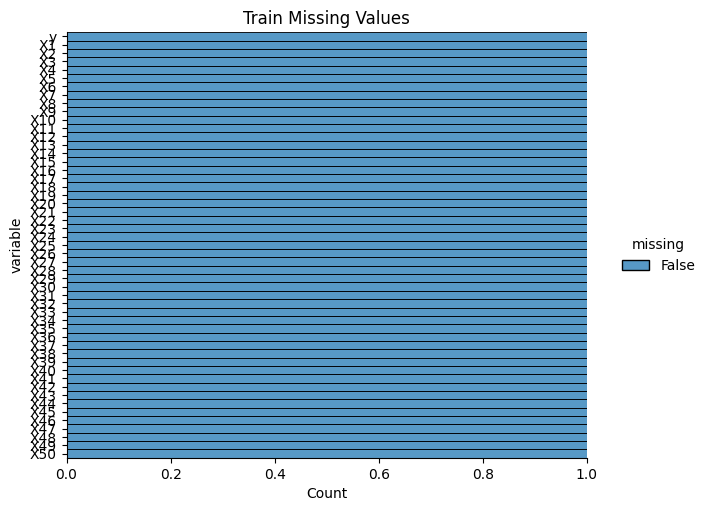

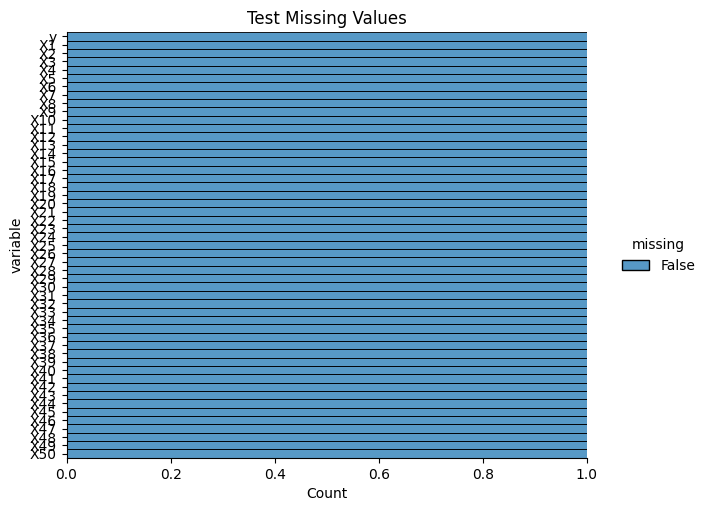

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(
    data=train.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.title('Train Missing Values')

sns.displot(
    data=test.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.title('Test Missing Values')

plt.show()

## MIQP Problem

### Formulation of the problem:

* **Decision variables:**
1. The $m$ coefficients of the variables:
$$\beta_0, \beta_1, \beta_2,..., \beta_m$$
2. The binary $z_j$ variables which decide which $\beta_j$ variables are 0
$$z_j \: are \: binary \: where \: j\in \{1, 2, ...m\}$$

* **Objective:** 
$$\boxed{min_{\beta}\Sigma^{n}_{i=1}(\beta_{0}+\beta_{1}x_{i1}+...+\beta_{m}x_{im}-y_i)^{2}}$$

where m is the number of variables to be selected

* **Constraints:**

1. First $m$ set of Big-M constraints:
$$-Mz_j\leq\beta_j\:for\:j\in\{1, 2, 3,..., m\}$$

2. Second $m$ set of Big-M constraints:
$$Mz_j\geq\beta_j\:for\:j\in\{1, 2, 3,..., m\}$$

**NOTE:** We choose the value of $M$ to arbitrarily be 100 (sufficiently large value).

3. Total number of variables picked should be less than or equal to $k$:
$$\Sigma_{j=1}^mz_{j}\leq k$$

In [5]:
def MIQP(df_train, k):

    # Setting the X and y variables

    X_train = df_train.drop(columns='y').to_numpy()
    y_train = df_train['y'].to_numpy()

    m = X_train.shape[1]
    M = 100
    sense = []
    b = []

    # Setting up the constraint matrix
    # We have 2*m+1 decision variables
    # First m big M constraints
    A = np.hstack((np.eye(m), -M*np.eye(m)))
    sense += ['<']*m
    b += [0]*m

    # Second m big M constraints
    A_1 = np.hstack((np.eye(m), M*np.eye(m)))
    sense += ['>']*m
    b += [0]*m
    A = np.vstack((A, A_1))

    # All z variables should add to <= k
    A_2 = np.array([0]*m + [1]*m)
    sense.append('<')
    b.append(k)
    A = np.vstack((A, A_2))

    # Adding a column of zeroes for the constant 
    A = np.hstack((np.array([0]*(2*m+1)).reshape((2*m+1, 1)), A))

    # Setting up the objective
    n_train = X_train.shape[0]
    X_train = np.hstack((np.ones((n_train, 1)), X_train))
    Q = np.zeros((2*m+1, 2*m+1))
    Q[:(m+1), :(m+1)] = X_train.T @ X_train
    L = np.zeros(2*m+1)
    L[:m+1] = -2*y_train.T @ X_train

    varMod = gp.Model()
    varMod_x = varMod.addMVar(2*m+1, vtype=np.array(['C']*(m+1) + ['B']*m), lb=np.array([np.NINF]+[-M]*(m)+ [np.NINF]*m))
    varMod_con = varMod.addMConstr(A, varMod_x, np.array(sense), np.array(b))
    varMod.setMObjective(Q, L, 0, sense = gp.GRB.MINIMIZE)
    varMod.setParam("OutputFlag",0)

    varMod.optimize()
    betas = varMod_x.x[:m+1] 

    return betas

## LASSO

In LASSO, variables are selected as:

$$\boxed{y_{predicted} = min_{\beta}(\Sigma^{n}_{i=1}(\beta_{0}+\beta_{1}x_{i1}+...+\beta_{m}x_{im}-y_i)^{2} + \lambda\Sigma_{j=1}^{m}|\beta_{j}|)}$$

Here, variables are set to 0 when lambda is large, penalizing the cost function. Note that $\beta_0$ is not included in the penalty term. When lambda is very large, the prediction of the regression is just the mean of the target variables.

Below, we implement the LassoCV function in scikit-learn, which automatically does k-fold cross validation for us to select $\lambda$.

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def LASSO(df_train, df_test):

    X_train = df_train.drop(columns='y').to_numpy()
    y_train = df_train['y'].to_numpy()
    X_test = df_test.drop(columns='y').to_numpy()
    y_test = df_test['y'].to_numpy()

    clf = linear_model.LassoCV(cv=10, normalize=True)
    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    MSE_train = mean_squared_error(y_train, y_pred_train)
    MSE_test = mean_squared_error(y_test, y_pred_test)

    num_var = (clf.coef_ !=0).sum()
    print('Best lambda from LASSO: {}'.format(clf.alpha_))
    print('Intercept: ', clf.intercept_)
    print('Number of X Variables: {}'.format(num_var))
    print('Beta coefs: ', clf.coef_)
    print('Train MSE: ', MSE_train)
    print('Test MSE: ', MSE_test)

    return np.array([clf.intercept_] + list(clf.coef_)), clf.alpha_, MSE_train, MSE_test

## SSE

Here we calculate the sum of squared errors for both the training set and the test set, according to:
$$SSE_{train} = (X_{train}\beta - y)^{T}*(X_{train}\beta - y)$$
$$SSE_{test} = (X_{test}\beta - y)^{T}*(X_{test}\beta - y)$$

In [7]:
def SSE(df_train, df_test, k):
    
    # Calculating the betas
    betas = MIQP(df_train, k)
    
    X_train = df_train.drop(columns='y').to_numpy()
    y_train = df_train['y'].to_numpy()
    X_test = df_test.drop(columns='y').to_numpy()
    y_test = df_test['y'].to_numpy()
    n_train = X_train.shape[0]
    X_train = np.hstack((np.ones((n_train, 1)), X_train))
    n_test = X_test.shape[0]
    X_test = np.hstack((np.ones((n_test, 1)), X_test))
    
    SSE_train = (X_train @ betas - y_train).T @ (X_train @ betas - y_train)
    SSE_test = (X_test @ betas - y_test).T @ (X_test @ betas - y_test)
    
    return SSE_train, SSE_test

## KFOLD

Here we implement 10-fold cross validation for the MIQP problem to select the value of $k$ (number of variables to be selected). 

In [8]:
import os

if os.path.exists('results_in_method_2.csv'):
    # Read the previously generated error file upon running the previous code block
    df_errors = pd.read_csv("kfold_MIQP.csv").drop(columns='Unnamed: 0')
else:
    # Shuffling datasets
    train_cv = train.sample(frac=1)
    k_list = [5*(i+1) for i in range(10)]

    folds = 10
    errors = []
    # KFold Cross validation
    for k in k_list:
        sum = 0
        for df_holdout in np.split(train_cv, folds):
            
            df_train = train_cv[~train_cv.index.isin(df_holdout.index)]
            SSE_train, SSE_holdout = SSE(df_train, df_holdout, k)
            sum += SSE_holdout
        avg_sum = sum
        errors.append(avg_sum)

    df_errors = pd.DataFrame({
        'k': k_list, 
        'Holdout_error': errors
    })
    
    df_errors.to_csv("kfold_MIQP.csv")

Errors dataframe: 

    k  Holdout_error
0   5     905.047754
1  10     732.848361
2  15     754.143193
3  20     773.865825
4  25     780.541226
5  30     805.951129
6  35     811.646425
7  40     817.453951
8  45     818.574317
9  50     816.277840


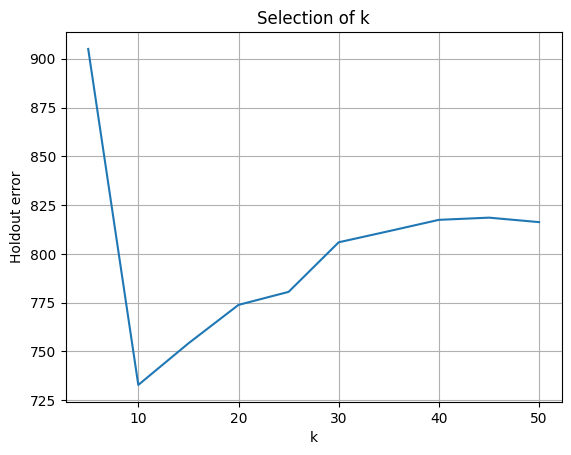

In [9]:
import matplotlib.pyplot as plt

print("Errors dataframe: \n")
print(df_errors)

# Plotting the errors
plt.plot(df_errors['k'], df_errors['Holdout_error'])
plt.title('Selection of k')
plt.xlabel('k')
plt.ylabel('Holdout error')
plt.grid()

The best $k$ is 10. This would imply that 10 variables are useful in predicting the output, the other variables are noise and contribute to overfitting.

## Fit MIQP on Entire Training Data with k=10

In [10]:
bet_miqp = MIQP(train, 10)
print('Beta coefs:')
bet_miqp

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-26
Beta coefs:


array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

## Fitting lasso on the training and testing datasets

Here we print out the $\lambda$, $\beta_0$, $k$, $\beta_j$, $MSE_{train}$ and $MSE_{test}$ for LASSO.

In [11]:
# Lasso
bet_lasso = LASSO(train, test)

Best lambda from LASSO: 0.0057453437864455085
Intercept:  1.0061963544057866
Number of X Variables: 18
Beta coefs:  [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -2.11561506  0.         -0.06043079 -0.
 -0.         -0.         -0.41674549 -0.18155256  0.          0.
 -0.          0.          0.         -0.19710223 -1.3655275   0.73510021
 -0.         -1.30018578  0.          0.          0.06390289  0.
 -0.          0.         -0.10737966  0.25392747  0.02138366  0.
  0.          0.         -0.21159473  0.         -0.          0.
  0.          0.01152326  1.53171531 -0.01408773  0.6504778  -0.09757869
  0.          0.        ]
Train MSE:  2.4009897950790076
Test MSE:  2.3597086675768346


## Comparing the MIQP and the LASSO problem

**Below we compare the predicted values of y for both the methods.**

In [12]:
# predict y on X_test by using beta vals from k=10
X_test = test.drop(columns='y').to_numpy()
y_test = test['y']
n_test = X_test.shape[0]
X_test = np.hstack((np.ones((n_test, 1)), X_test))
y_predict_miqp = X_test @ bet_miqp
y_predict_lasso = X_test @ bet_lasso[0]

print("The values of y predicted from MIQP problem are: \n")
print(y_predict_miqp)

print("The values of y predicted from LASSO are: \n")
print(y_predict_lasso)

The values of y predicted from MIQP problem are: 

[ 6.17985878  5.09524299  3.28559532  3.75848539 -0.33297526 -5.14273683
 -3.14454357 -1.23806288  1.38511093 -0.44173854 -1.69500225  2.73035027
  0.74744903 -0.97192232 -0.68681528  8.04522381 -7.94698471  3.89063974
 -4.58142919 -3.21992082 -2.16211454  3.21686318 -3.19810533  0.19740731
 -2.35988844 -0.41999885 -1.9125216  -3.32418587 -3.14170972 -3.55379324
 -1.80842543 -0.37134301  1.8670808   5.04927886 -1.80005614  3.09427675
  4.38154309  2.6988627   1.6132886   5.97584637 -1.1973583   5.2232542
 -5.84899891 -1.14461528  4.51802998  4.18774866  4.12046008  0.61483809
  1.95723246 -1.54904383]
The values of y predicted from LASSO are: 

[ 6.03825222  4.8649441   3.18119483  3.53168053 -0.45811526 -4.85193624
 -2.79173278 -1.44600095  1.39579841 -0.17881191 -1.95903628  2.70532632
  0.62547897 -0.45474384 -0.24671651  7.26275263 -7.4420549   3.60548489
 -4.34845018 -2.95351631 -1.89112059  3.33269462 -2.34452757  1.18116807
 -2.

In [13]:
# Comparing the test SSE from lasso and MIQP for the best k
lasso_test_MSE = bet_lasso[3]*len(y_predict_lasso)
MIQP_test_MSE = mean_squared_error(y_predict_miqp, y_test)
print(f"Test errors (MSE) for MIQP and LASSO are: {MIQP_test_MSE} and {lasso_test_MSE} respectively")

Test errors (MSE) for MIQP and LASSO are: 2.336543964552526 and 117.98543337884173 respectively


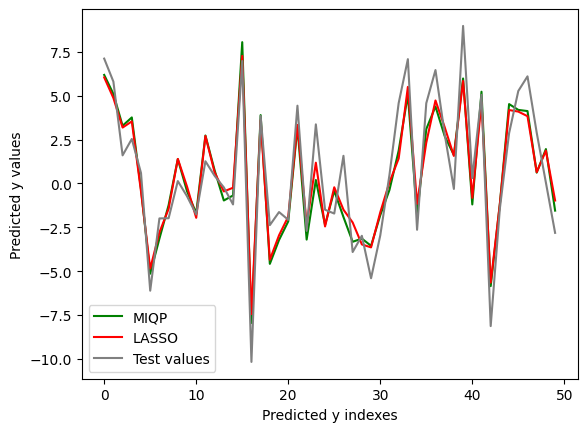

In [14]:
# Comparing predicted y values
plt.plot(y_predict_miqp, color='g', label='MIQP')
plt.plot(y_predict_lasso, color='red', label='LASSO')
plt.plot(y_test, color='grey', label='Test values')
plt.ylabel('Predicted y values')
plt.xlabel('Predicted y indexes')
plt.legend()

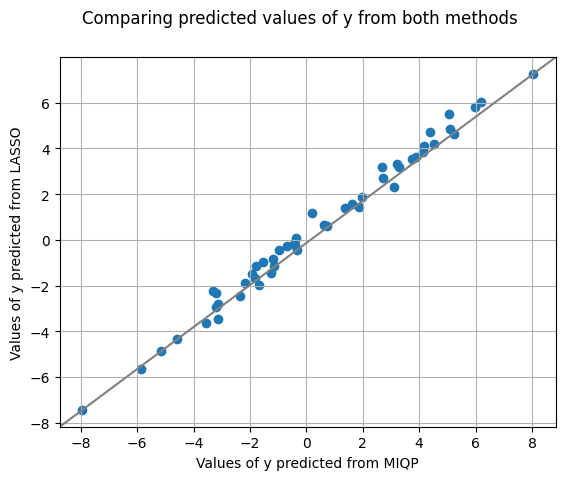

In [15]:
import matplotlib.lines as mlines

fig, ax = plt.subplots()

ax.scatter(y_predict_miqp, y_predict_lasso)
fig.suptitle('Comparing predicted values of y from both methods')
ax.set_xlabel('Values of y predicted from MIQP')
ax.set_ylabel('Values of y predicted from LASSO')

# Reference line
line = mlines.Line2D([0, 1], [0, 1], color='grey')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.grid()

We see that the points are very close to the diagonal. There is not much difference in terms of predictive power.

**Below we compare the observed coefficients for both methods**

Text(0.5, -0.1, 'Beta index')

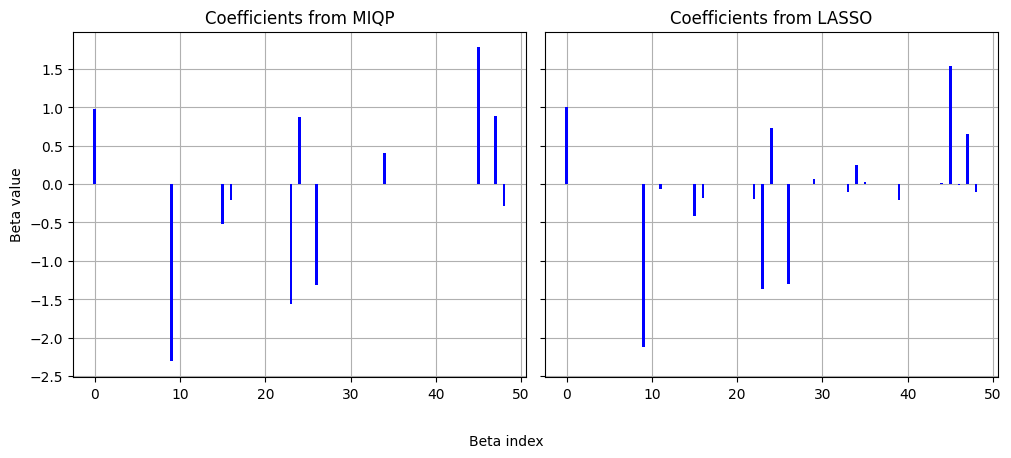

In [16]:
# Comparing the coefficients obtained from both methods
w_miqp = bet_miqp[bet_miqp!=0]
b_miqp = np.argwhere(bet_miqp!=0).T[0]
w_lasso = bet_lasso[0][bet_lasso[0]!=0]
b_lasso = np.argwhere(bet_lasso[0]!=0).T[0]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4), constrained_layout=True)

ax1.grid(zorder=0)
ax1.bar(b_miqp, w_miqp, width=0.3, align='center', color='blue', zorder=3)
ax1.set_title('Coefficients from MIQP')
ax1.set_ylabel('Beta value')

ax2.grid(zorder=0)
ax2.bar(b_lasso, w_lasso, width=0.3, align='center', color='blue', zorder=3)
ax2.set_title('Coefficients from LASSO')
fig.text(0.5, -0.1,"Beta index", ha='center')

We see that the coefficient values for both the MIQP and LASSO are almost the same and there are many coefficients that are almost zero in lasso. This implies that as far as subset selection, it is not as good as the MIQP, but very close.

## Recommendation:

In terms of subset selection, we find that solving the MIQP is more accurate and exactly zeros out the required variables, whereas if only prediction is necessary, there is not much use to solving the harder problem (MIQP) and would be more advantageous to select the computationally cheaper LASSO.